# Web Scrapping
*[Cyril Pecoraro](http://github.com/cyril-p)*

**Scrapping Data from the Web**

In this project we will extract interesting information from IS-Academia, the educational portal of EPFL. Specifically, we will focus on the part that allows public access to academic [data](http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247). 


We will obtain all the data for the "informatique" Bachelor students, starting from 2007. We will keep only the students for which we have an entry for both Bachelor semestre 1 and Bachelor semestre 6. We will compute how many months it took each student to go from the first to the sixth semester. We will partition the data between male and female students, and compute the average and find if the difference in average is statistically significant?

In [103]:
import requests 
import pandas as pd
from scipy import stats
import urllib3
% matplotlib inline
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt

We have a BaseFormUrl, and from there, we will get the tags for the type of results, and every choice in the menu on the left of the page.

The idea is to hardcode the name of the parameters and get their possible values. 
Parameters are : 
'ww_i_reportModelXsl','ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE'

In [5]:
# We define two url: One for selecting the parameters, one for displaying the student names.
baseFormUrl = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247'
baseFormUrlDisplay = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?ww_b_list=1&ww_i_reportmodel=133685247'

r = requests.get(baseFormUrl)
soup = BeautifulSoup(r.content, "html.parser")

The idea is to put all the params needed and their possible values in a nested dictionary named 'ww_params'

We select the format of the page in the table with tag 'format'. Data is available in html or XLS, but we choose to use html.

In [6]:
ww_params = dict()
formatTable = soup.find('table',attrs={'id': 'format'})
try:
    value = formatTable.findAll('input', attrs={'name':"ww_i_reportModelXsl"})
except:
    pass
value_ww_i_reportModelXsl = value[0]['value']
ww_params["ww_i_reportModelXsl"] = value_ww_i_reportModelXsl

And so we get the possible values for the parameters 'ww_i_reportModelXsl','ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE'.

In [7]:
filtreName = ['ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE']
filtreTable = soup.find('table',attrs={'id': 'filtre'})

for name in filtreName:
    ww_paramsList = dict()
    academicChoice = filtreTable.find('select',attrs={'name': name})
    value_ww_x_UNITE_ACAD = []
    try:
        choice = academicChoice.findAll('option')
    except:
        print('error')
        pass
    for option in choice:
        if (option['value']) != 'null':
            ww_paramsList[option.text]=option['value']
    ww_params[name] = ww_paramsList

Now we load the data by building a custom URL.  We first need to select the IS-Academia code for the parameters Bachelor 1 and Bachelor 6, fall semester and Spring semester, HTML Result, Informatique section

In [8]:
#Load the IS-academia code for html results and return error if there is a problem
htmlResult = ww_params.get('ww_i_reportModelXsl', 'error')

#Load the IS-academia code for fall semester and return error if there is a problem
fallSemester = ww_params.get('ww_x_HIVERETE').get('Semestre d\'automne', 'error')

#Load the IS-academia code for fall semester and return error if there is a problem
springSemester = ww_params.get('ww_x_HIVERETE').get('Semestre de printemps', 'error')

#Load the IS-academia code for bachelor 1 and return error if there is a problem
bachelor1 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Bachelor semestre 1', 'error')

#Load the IS-academia code for bachelor 6 and return error if there is a problem
bachelor6 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Bachelor semestre 6', 'error')

#Load the IS-academia code for Informatique and return error if there is a problem
informatique = ww_params.get('ww_x_UNITE_ACAD').get('Informatique', 'error')

But before getting the list of the student, we need to have another parameter "ww_x_GPS". 
2 calls will be made. The first one  will allow to obtain the ww_x_GPS, and the second one to load the students, using that ww_x_GPS.

Sometimes ww_x_GPS is not available, in this case, nothing will be done.

This solution is quite slow (but works).

In [9]:
#DataFrame of bachelor1 students. We already know the names of the columns
bachelor1DataFrame = pd.DataFrame(columns=('sex','name','sciper','year'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    ###First Call
    #Build the url:
    url = baseFormUrl + '&ww_b_list=1' + \
    '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
    '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
    '&ww_x_PERIODE_PEDAGO=' + bachelor1+ \
    '&ww_x_HIVERETE=' + fallSemester

    #Make a request
    r = requests.get(url)

    #Parse the URL with beautifulSoup
    soup = BeautifulSoup(r.content, "html.parser")

    #find the parameter ww_x_GPS (if it exists).
    try:
        value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
        #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
        #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
        for val in value:
            #We are only interested in the value that is not -1
            if val['onclick'] != -1:
                position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                position_ww_x_GPS_end = substringBeginning.find('\'')
                ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
        ###Second call
        #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
        #Here the base Url changes because we display names.
        url = baseFormUrlDisplay + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + bachelor1+ \
        '&ww_x_HIVERETE=' + fallSemester + \
        '&ww_x_GPS=' + ww_x_GPS
         #Make a request
        r = requests.get(url)
        #Parse the page with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        my_table = soup.find('table')
        rows = my_table.findChildren(['th', 'tr'])
        
        for row in rows:
            cells = row.findChildren('td')
            #We already know the format of the data so we can simply select the desired columns
            if len(cells) == 12:
                sex = cells[0].find(text=True)
                name = cells[1].find(text=True)
                sciper = cells[10].find(text=True)
                #Let's keep only the first year of the string year. The year is given in the form 20XX-20XY. 
                #We will keep 20XX
                year = year[:4]
                
                s = pd.Series([sex,name,sciper,year],index=['sex','name','sciper','year'])
                bachelor1DataFrame = bachelor1DataFrame.append(s, ignore_index=True)

    except:
        pass

bachelor1DataFrame.head(10)

sex                      name  sciper  year
0  Monsieur           Abbey Alexandre  235688  2015
1    Madame             Abboud Magaly  249344  2015
2  Monsieur               Ahmed Fares  246443  2015
3  Monsieur     Alder Jean-Marie René  259105  2015
4    Madame     Amirthalingam Ajantha  262227  2015
5  Monsieur             Amrani Mounir  246447  2015
6  Monsieur           Andreu Philippe  253656  2015
7  Monsieur           Arslanagic Alen  264333  2015
8    Madame  Baert-Yue Antonine Elisa  261867  2015
9  Monsieur            Bagnoud Jérôme  262214  2015

In [11]:
#DataFrame of bachelor6 students. We already know the names of the columns
bachelor6DataFrame = pd.DataFrame(columns=('sex','name','sciper','year'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    ###First Call
    #Build the url:
    url = baseFormUrl + '&ww_b_list=1' + \
    '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
    '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
    '&ww_x_PERIODE_PEDAGO=' + bachelor6+ \
    '&ww_x_HIVERETE=' + springSemester

    #Make a request
    r = requests.get(url)

    #Parse the URL with beautifulSoup
    soup = BeautifulSoup(r.content, "html.parser")

    #find the parameter ww_x_GPS (if it exists).
    try:
        value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
        #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
        #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
        for val in value:
            #We are only interested in the value that is not -1
            if val['onclick'] != -1:
                position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                position_ww_x_GPS_end = substringBeginning.find('\'')
                ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
        ###Second call
        #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
        #Here the base Url changes because we display names.
        url = baseFormUrlDisplay + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + bachelor6+ \
        '&ww_x_HIVERETE=' + springSemester + \
        '&ww_x_GPS=' + ww_x_GPS
         #Make a request
        r = requests.get(url)
        #Parse the page with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        my_table = soup.find('table')
        rows = my_table.findChildren(['th', 'tr'])
        
        for row in rows:
            cells = row.findChildren('td')
            #We already know the format of the data so we can simply select the desired columns
            if len(cells) == 12:
                sex = cells[0].find(text=True)
                name = cells[1].find(text=True)
                sciper = cells[10].find(text=True)
                #Let's keep only the first year of the string year. The year is given in the form 20XX-20XY. 
                #We will keep 20XX
                year = year[:4]
                s = pd.Series([sex,name,sciper,year],index=['sex','name','sciper','year'])
                bachelor6DataFrame = bachelor6DataFrame.append(s, ignore_index=True)

    except:
        pass

bachelor6DataFrame.head(10)

sex                               name  sciper  year
0  Monsieur                Aiulfi Loris Sandro  202293  2015
1  Monsieur          Alfonso Peterssen Alfonso  228219  2015
2  Monsieur           Alonso Seisdedos Florian  215576  2015
3  Monsieur  Angerand Grégoire Georges Jacques  212464  2015
4  Monsieur      Anongba Varela Dario Abougnan  226371  2015
5    Madame                       Baraschi Zoé  219665  2015
6  Monsieur         Birchmeier Alain Dominique  227120  2015
7  Monsieur       Boissaye Arnaud Didier Marie  214939  2015
8  Monsieur                Bonfils Nils Pascal  236802  2015
9  Monsieur                       Bonnome Hugo  227370  2015

## Data cleaning

We can see that some students are present several times. Some students have done bachelor 6 twice or more. We will keep only the latest year.

In [12]:
c_maxs = bachelor6DataFrame.groupby('sciper').year.transform(max)
bachelor6DataFrame = bachelor6DataFrame[bachelor6DataFrame.year == c_maxs]

Similarly, there are duplicates in the bachelor1 DataFrame. Some students have done bachelor 1 twice. 
We will keep only the earliest date, as it is the first time they were in Bachelor1

In [13]:
c_mins = bachelor1DataFrame.groupby('sciper').year.transform(min)
bachelor1DataFrame = bachelor1DataFrame[bachelor1DataFrame.year == c_mins]

### Merge DataFrames 
keep students that are present only in both dataFrames. This is an inner joint of the 2 dataframes

In [14]:
bachelorStudentsDataFrame = pd.merge(bachelor1DataFrame, bachelor6DataFrame, how='inner', on=['sex', 'name', 'sciper'], suffixes=('_bachelor1', '_bachelor6'))
bachelorStudentsDataFrame.head(10)

sex                              name  sciper year_bachelor1  \
0  Monsieur                Abate Bryan Jeremy  246671           2014   
1  Monsieur                 Alami-Idrissi Ali  251759           2014   
2  Monsieur                     Aoun Leonardo  249498           2014   
3  Monsieur          Bachmann Roman Christian  234551           2014   
4  Monsieur              Beck Johannes Magnus  247328           2014   
5  Monsieur                      Benlalah Ali  251758           2014   
6  Monsieur          Bovel Matthieu Alexandre  250300           2014   
7  Monsieur  Burgelin Clément Louis Alexandre  249954           2014   
8  Monsieur              Coudert Rémi Edouard  249996           2014   
9    Madame                   Evrova Gabriela  239489           2014   

  year_bachelor6  
0           2016  
1           2016  
2           2016  
3           2016  
4           2016  
5           2016  
6           2016  
7           2016  
8           2016  
9           2016

We put the types of the sciper and years as int.

In [15]:
bachelorStudentsDataFrame[['sciper','year_bachelor6', 'year_bachelor1']] = bachelorStudentsDataFrame[['sciper','year_bachelor6', 'year_bachelor1']].astype(int)

There are no more duplicates in the complete bachelorStudentsDataFrame.

In [16]:
bachelorStudentsDataFrame.duplicated('sciper').sum()

0

### Number of months
There are 10 months between september and July for 1 year. Let's compute the number of month needed for each student to go from bachelor 1 to bachelor 6.

In [34]:
def number_months(x): 
    return (x['year_bachelor6']-x['year_bachelor1'])*12 + 10

bachelorStudentsDataFrame['number_months'] = bachelorStudentsDataFrame.apply(number_months, axis = 1) 

In [35]:
bachelorStudentsDataFrame.sort_values('name').head(10)

sex                                         name  sciper  \
0    Monsieur                           Abate Bryan Jeremy  246671   
152  Monsieur                          Aiulfi Loris Sandro  202293   
1    Monsieur                            Alami-Idrissi Ali  251759   
105  Monsieur                    Alfonso Peterssen Alfonso  228219   
254  Monsieur                     Alonso Seisdedos Florian  215576   
255  Monsieur  Amorim Afonso Caldeira Da Silva Pedro Maria  213618   
256  Monsieur                   Andreina Sébastien Laurent  215623   
153  Monsieur                                   Angel Axel  201284   
257  Monsieur            Angerand Grégoire Georges Jacques  212464   
209  Monsieur                              Antognini Marco  194182   

     year_bachelor1  year_bachelor6  number_months  
0              2014            2016             34  
152            2010            2015             70  
1              2014            2016             34  
105            2013            2015             34  
254            2011            2015             58  
255            2011            2014             46  
256            2011            2014             46  
153            2010            2012             34  
257            2011            2015             58  
209            2009            2012             46

### Partition in male/female
we will construct two dataFrames, one for females, the other for males.

In [36]:
bachelorFemaleStudentsDataFrame = bachelorStudentsDataFrame[bachelorStudentsDataFrame['sex'] == 'Madame']
bachelorMaleStudentsDataFrame = bachelorStudentsDataFrame[bachelorStudentsDataFrame['sex']=='Monsieur']

Number of female students:

In [37]:
bachelorFemaleStudentsDataFrame['sciper'].count()

29

Number of male students:

In [38]:
bachelorMaleStudentsDataFrame['sciper'].count()

368

## Data analysis
The main quesiton is : "For the number of months between bachelor 1 and 6, is the difference in average statistically significant between male and female students?"

First let's have a look at the data


We can see that most of the female students completed their bachelor in 2 years, and a few did it in 3 years.

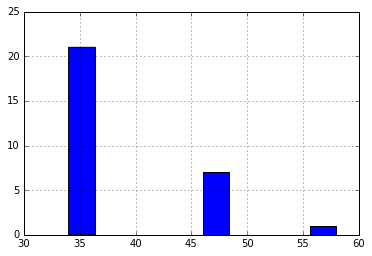

In [39]:
bachelorFemaleStudentsDataFrame['number_months'].hist()

**The mean is at 37.72 months**

In [19]:
bachelorFemaleStudentsDataFrame['number_months'].describe()

count    29.000000
mean     37.724138
std       6.496684
min      34.000000
25%      34.000000
50%      34.000000
75%      46.000000
max      58.000000
Name: number_months, dtype: float64

We can see that most of the male students completed their bachelor in 2 years, and a few did it in 3 years, and some in 70 months.

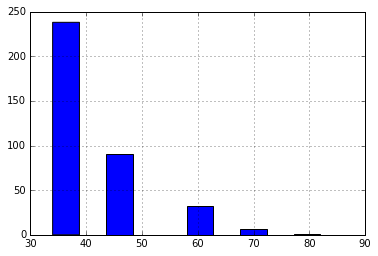

In [40]:
bachelorMaleStudentsDataFrame['number_months'].hist()

**The mean is at 39.77**

In [41]:
bachelorMaleStudentsDataFrame['number_months'].describe()

count    368.000000
mean      39.771739
std        8.943788
min       34.000000
25%       34.000000
50%       34.000000
75%       46.000000
max       82.000000
Name: number_months, dtype: float64

In [42]:
bachelorMaleStudentsDataFrame.loc[bachelorMaleStudentsDataFrame['number_months']==82]

sex         name  sciper  year_bachelor1  year_bachelor6  \
238  Monsieur  Perrin Sami  196034            2009            2015   

     number_months  
238             82

### Statistical tests
"For the number of months between bachelor 1 and 6, is the difference in average statistically significant between male and female students?"

We will perform a Welch’s t-test, because the variance, mean and sample size are different. 
See doc of the function used [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)


H0: "Both population have equal mean"
H1: "The means are different"

In [43]:
stats.ttest_ind(bachelorMaleStudentsDataFrame['number_months'], bachelorFemaleStudentsDataFrame['number_months'], equal_var = False)

Ttest_indResult(statistic=1.5831651359439409, pvalue=0.12191236829650401)

With a p-value that is above 0.05 and t-statistic < 1,95, we can not reject H0. 

**Conclusion : there is no significant difference in average between male and female students**

# Question 2 - Master Student

### Building dataframes

Defining IS-academia codes for Master 1, Master 2, Master 3 and Master thesis

In [44]:
#Load the IS-academia code for Master 1 and return error if there is a problem
master1 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Master semestre 1', 'error')

#Load the IS-academia code for Master 2 and return error if there is a problem
master2 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Master semestre 2', 'error')

#Load the IS-academia code for Master 3 and return error if there is a problem
master3 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Master semestre 3', 'error')

#Load the IS-academia code for Projet master automne and return error if there is a problem
pdm_a = ww_params.get('ww_x_PERIODE_PEDAGO').get('Projet Master automne', 'error')

#Load the IS-academia code for Projet master printemps and return error if there is a problem
pdm_p = ww_params.get('ww_x_PERIODE_PEDAGO').get('Projet Master printemps', 'error')

pdm= [pdm_a, pdm_p] # We get the two codes for Master thesis into one variable


Now fill a dataFrame with students enrolled in Master 1 using beautifulSoup.

In [50]:
#DataFrame of Master 1 students. We already know the names of the columns
master1DataFrame = pd.DataFrame(columns=('sex','name','sciper','year','specialisation', 'mineur'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    for semester in ww_params.get('ww_x_HIVERETE'):
        ###First Call
        #Build the url:
        url = baseFormUrl + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + master1+ \
        '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester)

        #Make a request
        r = requests.get(url)

        #Parse the URL with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        #find the parameter ww_x_GPS (if it exists).
        try:
            value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
            #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
            #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
            for val in value:
                #We are only interested in the value that is not -1
                if val['onclick'] != -1:
                    position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                    substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                    position_ww_x_GPS_end = substringBeginning.find('\'')
                    ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
            ###Second call
            #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
            #Here the base Url changes because we display names.
            url = baseFormUrlDisplay + '&ww_b_list=1' + \
            '&ww_i_reportModelXsl=' + htmlResult + \
            '&ww_x_UNITE_ACAD=' + informatique + \
            '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
            '&ww_x_PERIODE_PEDAGO=' + master1+ \
            '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester) + \
            '&ww_x_GPS=' + ww_x_GPS
             #Make a request
            r = requests.get(url)
            #Parse the page with beautifulSoup
            soup = BeautifulSoup(r.content, "html.parser")

            my_table = soup.find('table')
            rows = my_table.findChildren(['th', 'tr'])
        
            for row in rows:
                cells = row.findChildren('td')
                #We already know the format of the data so we can simply select the desired columns
                if len(cells) == 12:
                    sex = cells[0].find(text=True)
                    name = cells[1].find(text=True)
                    specialisation = cells[4].find(text=True)
                    mineur = cells[6].find(text=True)
                    sciper = cells[10].find(text=True)
                    #The year will be defined such as 2014 if it is spring semester in 2014
                    #and 2014.5 if it is automn semester in 2014
                    if semester=='Semestre d\'automne':
                        annee = float(year[:4])+0.5 
                    else:
                        annee=float(year[5:])
                    s = pd.Series([sex,name,sciper,annee,specialisation,mineur],index=['sex','name','sciper','year', 'specialisation', 'mineur'])
                    master1DataFrame = master1DataFrame.append(s, ignore_index=True)

        except:
            pass

master1DataFrame.head(10)

sex                                         name  sciper    year  \
0    Madame                                Abi Akar Nora  251253  2015.5   
1    Madame                                  Aeby Prisca  225654  2015.5   
2  Monsieur                  Alnasser Riyadh Abdulaziz M  257825  2015.5   
3  Monsieur                               Amiguet Jérôme  166075  2015.5   
4  Monsieur  Amorim Afonso Caldeira Da Silva Pedro Maria  213618  2015.5   
5  Monsieur                   Andreina Sébastien Laurent  215623  2015.5   
6  Monsieur                       Antognini Diego Matteo  243163  2015.5   
7  Monsieur                                Balaban Metin  251470  2015.5   
8  Monsieur                         Beguet Romain Michel  226638  2015.5   
9  Monsieur                                    Bell Enea  248358  2015.5   

  specialisation mineur  
0           None   None  
1           None   None  
2           None   None  
3           None   None  
4           None   None  
5           None   None  
6           None   None  
7           None   None  
8           None   None  
9           None   None

Likewise, building dataframe Master 2

In [51]:

#DataFrame of Master 2 students. We already know the names of the columns
master2DataFrame = pd.DataFrame(columns=('sex','name','sciper','year','specialisation', 'mineur'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    for semester in ww_params.get('ww_x_HIVERETE'):
        ###First Call
        #Build the url:
        url = baseFormUrl + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + master2+ \
        '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester)

        #Make a request
        r = requests.get(url)

        #Parse the URL with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        #find the parameter ww_x_GPS (if it exists).
        try:
            value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
            #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
            #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
            for val in value:
                #We are only interested in the value that is not -1
                if val['onclick'] != -1:
                    position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                    substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                    position_ww_x_GPS_end = substringBeginning.find('\'')
                    ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
            ###Second call
            #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
            #Here the base Url changes because we display names.
            url = baseFormUrlDisplay + '&ww_b_list=1' + \
            '&ww_i_reportModelXsl=' + htmlResult + \
            '&ww_x_UNITE_ACAD=' + informatique + \
            '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
            '&ww_x_PERIODE_PEDAGO=' + master2+ \
            '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester) + \
            '&ww_x_GPS=' + ww_x_GPS
             #Make a request
            r = requests.get(url)
            #Parse the page with beautifulSoup
            soup = BeautifulSoup(r.content, "html.parser")

            my_table = soup.find('table')
            rows = my_table.findChildren(['th', 'tr'])
        
            for row in rows:
                cells = row.findChildren('td')
                #We already know the format of the data so we can simply select the desired columns
                if len(cells) == 12:
                    sex = cells[0].find(text=True)
                    name = cells[1].find(text=True)
                    specialisation = cells[4].find(text=True)
                    mineur = cells[6].find(text=True)
                    sciper = cells[10].find(text=True)
                    #The year will be defined such as 2014 if it is spring semester in 2014
                    #and 2014.5 if it is automn semester in 2014
                    if semester=='Semestre d\'automne':
                        annee = float(year[:4])+0.5
                    else:
                        annee=float(year[5:])
                    s = pd.Series([sex,name,sciper,annee,specialisation,mineur],index=['sex','name','sciper','year', 'specialisation', 'mineur'])
                    master2DataFrame = master2DataFrame.append(s, ignore_index=True)

        except:
            pass

master2DataFrame.head(10)

sex                                         name  sciper    year  \
0    Madame                                Abi Akar Nora  251253  2016.0   
1    Madame                                  Aeby Prisca  225654  2016.0   
2  Monsieur                  Alnasser Riyadh Abdulaziz M  257825  2016.0   
3  Monsieur                               Amiguet Jérôme  166075  2016.0   
4  Monsieur  Amorim Afonso Caldeira Da Silva Pedro Maria  213618  2016.0   
5  Monsieur                   Andreina Sébastien Laurent  215623  2016.0   
6  Monsieur                       Antognini Diego Matteo  243163  2016.0   
7  Monsieur                              Antognini Marco  194182  2016.0   
8  Monsieur                                Balaban Metin  251470  2016.0   
9  Monsieur                         Beguet Romain Michel  226638  2016.0   

                 specialisation mineur  
0                          None   None  
1  Internet Information Systems   None  
2                          None   None  
3                          None   None  
4                          None   None  
5     Information Security - SP   None  
6                          None   None  
7       Foundations of Software   None  
8                          None   None  
9       Foundations of Software   None

Let's now build the dataframe for Master 3 student

In [52]:

#DataFrame of Master 2 students. We already know the names of the columns
master3DataFrame = pd.DataFrame(columns=('sex','name','sciper','year','specialisation', 'mineur'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    for semester in ww_params.get('ww_x_HIVERETE'):
        ###First Call
        #Build the url:
        url = baseFormUrl + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + master3+ \
        '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester)

        #Make a request
        r = requests.get(url)

        #Parse the URL with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        #find the parameter ww_x_GPS (if it exists).
        try:
            value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
            #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
            #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
            for val in value:
                #We are only interested in the value that is not -1
                if val['onclick'] != -1:
                    position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                    substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                    position_ww_x_GPS_end = substringBeginning.find('\'')
                    ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
            ###Second call
            #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
            #Here the base Url changes because we display names.
            url = baseFormUrlDisplay + '&ww_b_list=1' + \
            '&ww_i_reportModelXsl=' + htmlResult + \
            '&ww_x_UNITE_ACAD=' + informatique + \
            '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
            '&ww_x_PERIODE_PEDAGO=' + master3+ \
            '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester) + \
            '&ww_x_GPS=' + ww_x_GPS
             #Make a request
            r = requests.get(url)
            #Parse the page with beautifulSoup
            soup = BeautifulSoup(r.content, "html.parser")

            my_table = soup.find('table')
            rows = my_table.findChildren(['th', 'tr'])
        
            for row in rows:
                cells = row.findChildren('td')
                #We already know the format of the data so we can simply select the desired columns
                if len(cells) == 12:
                    sex = cells[0].find(text=True)
                    name = cells[1].find(text=True)
                    specialisation = cells[4].find(text=True)
                    mineur = cells[6].find(text=True)
                    sciper = cells[10].find(text=True)
                    #The year will be defined such as 2014 if it is spring semester in 2014
                    #and 2014.5 if it is automn semester in 2014
                    if semester=='Semestre d\'automne':
                        annee = float(year[:4])+0.5
                    else:
                        annee=float(year[5:])
                    s = pd.Series([sex,name,sciper,annee,specialisation,mineur],index=['sex','name','sciper','year', 'specialisation', 'mineur'])
                    master3DataFrame = master3DataFrame.append(s, ignore_index=True)

        except:
            pass

master3DataFrame.head(10)

sex                           name  sciper    year  \
0  Monsieur                Antognini Marco  194182  2015.5   
1    Madame         Bagcioglu Egeyar Özlen  232468  2015.5   
2  Monsieur              Basil John Sachin  245311  2015.5   
3  Monsieur                     Beau Joris  204569  2015.5   
4  Monsieur              Benhamadi Yassine  185991  2015.5   
5  Monsieur                   Berdat Johan  204393  2015.5   
6  Monsieur  Bodin Antoine Philippe Michel  245475  2015.5   
7  Monsieur                 Bougacha Malik  186264  2015.5   
8  Monsieur               Boullier Jocelyn  205541  2015.5   
9  Monsieur               Bouquet Stéphane  213664  2015.5   

                   specialisation  \
0         Foundations of Software   
1              Internet computing   
2                Software Systems   
3                            None   
4              Internet computing   
5  Signals, Images and Interfaces   
6                            None   
7                            None   
8                            None   
9                            None   

                                              mineur  
0                                               None  
1                                               None  
2                                               None  
3                   Mineur en Technologies spatiales  
4                                               None  
5                                               None  
6                    Mineur en Ingénierie financière  
7                                               None  
8                                               None  
9  Mineur en Management, technologie et entrepren...

Finally, let's build the dataframe for Master thesis

We are going to make a dataFrame for Master thesis Automn and Master thesis Spring. We will not save that information anywhere in the dataframe as we already have the information if it is in spring or automn by considering the year. 
2014-> spring semester 2014.5-> automn semester

In [53]:

#DataFrame of Master thesis students. We already know the names of the columns
pdmDataFrame = pd.DataFrame(columns=('sex','name','sciper','year','specialisation', 'mineur'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    for semester in ww_params.get('ww_x_HIVERETE'):
        
        #If we are looking at the autmon semester we are gonna look for "Projet Master automne" and if we are
        #searching in spring we will look for "Projet Master printemps" for the period academic
        if semester=='Semestre d\'automne':
            project=pdm_a
        else:
            project=pdm_p
            
        ###First Call
        #Build the url:
        url = baseFormUrl + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + project+ \
        '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester)

        #Make a request
        r = requests.get(url)

        #Parse the URL with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        #find the parameter ww_x_GPS (if it exists).
        try:
            value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
            #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
            #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
            for val in value:
                #We are only interested in the value that is not -1
                if val['onclick'] != -1:
                    position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                    substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                    position_ww_x_GPS_end = substringBeginning.find('\'')
                    ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
            ###Second call
            #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
            #Here the base Url changes because we display names.
            url = baseFormUrlDisplay + '&ww_b_list=1' + \
            '&ww_i_reportModelXsl=' + htmlResult + \
            '&ww_x_UNITE_ACAD=' + informatique + \
            '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
            '&ww_x_PERIODE_PEDAGO=' + project+ \
            '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester) + \
            '&ww_x_GPS=' + ww_x_GPS
             #Make a request
            r = requests.get(url)
            #Parse the page with beautifulSoup
            soup = BeautifulSoup(r.content, "html.parser")

            my_table = soup.find('table')
            rows = my_table.findChildren(['th', 'tr'])
        
            for row in rows:
                cells = row.findChildren('td')
                #We already know the format of the data so we can simply select the desired columns
                if len(cells) == 12:
                    sex = cells[0].find(text=True)
                    name = cells[1].find(text=True)
                    specialisation = cells[4].find(text=True)
                    mineur = cells[6].find(text=True)
                    sciper = cells[10].find(text=True)
                    #The year will be defined such as 2014 if it is spring semester in 2014
                    #and 2014.5 if it is automn semester in 2014
                    if semester=='Semestre d\'automne':
                        annee = float(year[:4])+0.5
                    else:
                        annee=float(year[5:])
                    s = pd.Series([sex,name,sciper,annee,specialisation,mineur],index=['sex','name','sciper','year', 'specialisation', 'mineur'])
                    pdmDataFrame = pdmDataFrame.append(s, ignore_index=True)

        except:
            pass

pdmDataFrame.head(10)

sex                    name  sciper    year      specialisation  \
0  Monsieur  Hahling Robin Philippe  233184  2015.5                None   
1  Monsieur              Jin Jialei  233543  2015.5                None   
2  Monsieur       Sarfati Alexandre  185301  2014.5                None   
3  Monsieur        Brutsche Florian  159852  2008.0  Internet computing   
4  Monsieur             Dotta Mirco  153819  2008.0                None   
5  Monsieur           Hügli Michael  145957  2008.0                None   
6  Monsieur           Indra Saurabh  173257  2008.0                None   
7  Monsieur            Lépine Simon  160150  2008.0        Biocomputing   
8  Monsieur          Stewart Conail  173527  2008.0                None   
9  Monsieur          Stewart Conail  173527  2007.5                None   

                   mineur  
0                    None  
1  Mineur en Biocomputing  
2                    None  
3                    None  
4                    None  
5                    None  
6                    None  
7                    None  
8                    None  
9                    None

### Merging dataFrames

First, we are going to handle duplicates. If a student was registered twice in Master 1, we will keep only the earliest one. If a student was registered twice in master 2, we will keep the earliest and the latest. Finally if he was twice in master 3, or in master thesis we will keep the latest registration.

This is based on the assumption that a student can start his master either in Master 1 or in Master 2 and that he can finish his last semester of courses either in Master 2 or 3.

We are also going to replace all the None by Nan, as it is easier to handle for us.

In [54]:
#Keeping the earliest registration for master 1
c_mins = master1DataFrame.groupby('sciper').year.transform(min)
master1DataFrame = master1DataFrame[master1DataFrame.year == c_mins]
master1DataFrame.fillna(value=np.nan, inplace=True)

#Keeping the earliest registration for master 2 
p_mins = master2DataFrame.groupby('sciper').year.transform(min)
master2DataFrame_e = master2DataFrame[master2DataFrame.year == p_mins]
master2DataFrame_e.fillna(value=np.nan, inplace=True)

#Keeping the latest registration for master 2 
c_maxs = master2DataFrame.groupby('sciper').year.transform(max)
master2DataFrame_l = master2DataFrame[master2DataFrame.year == c_maxs]
master2DataFrame_l.fillna(value=np.nan, inplace=True)


#Keeping the latest registration for master 3 
d_maxs = master3DataFrame.groupby('sciper').year.transform(max)
master3DataFrame = master3DataFrame[master3DataFrame.year == d_maxs]
master3DataFrame.fillna(value=np.nan, inplace=True)


#Keeping the latest registration for master thesis
p_maxs = pdmDataFrame.groupby('sciper').year.transform(max)
pdmDataFrame = pdmDataFrame[pdmDataFrame.year == p_maxs]
pdmDataFrame.fillna(value=np.nan, inplace=True)



C:\Users\Mathieu\Anaconda3\lib\site-packages\pandas\core\frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


We are now going to make an outer-join between master 1 and the earliest registration in master 2. The results of that join will then be left joined with the latest registratoins in master 2. This allows us to keep both dates of registration to master 2 in the dataframe.

We assume that if someone is registered in a minor or specialisation, he is registered in it alonz all his master semesters, so we also join on specialisation and minor.

In [55]:
master1_2 = pd.merge(master1DataFrame, master2DataFrame_e, how='outer', on=['sex', 'name', 'sciper','mineur','specialisation'], suffixes=('_master1', '_master2_earliest'))
master1_2 = pd.merge(master1_2, master2DataFrame_l, how='left', on=['sex', 'name', 'sciper','mineur','specialisation'], suffixes=('_master1', '_master2'))
master1_2 = master1_2.rename(columns={'year': 'year_master2_latest'}) #Renaming column year that comes from dataframe master 3 to year_master 3

master1_2.tail(10)

sex                      name  sciper  year_master1  \
1103  Monsieur           Kromwijk Sander  194430           NaN   
1104  Monsieur        Moreno Santos Igor  222381           NaN   
1105  Monsieur            Signo' Tiziano  226511           NaN   
1106    Madame          Sima Ana Claudia  226541           NaN   
1107  Monsieur  Stucki Nicolas Alexander  226421           NaN   
1108  Monsieur              Vallone Joël  183984           NaN   
1109  Monsieur              Vanini Erico  192668           NaN   
1110  Monsieur           Viaccoz Thierry  195916           NaN   
1111  Monsieur     Zablotchi Mihail Igor  192870           NaN   
1112  Monsieur       Dezfuli Seyyed Sina  268709           NaN   

                 specialisation                      mineur  \
1103                        NaN      Mineur en Biocomputing   
1104    Foundations of Software                         NaN   
1105         Internet computing                         NaN   
1106           Software Systems                         NaN   
1107    Foundations of Software                         NaN   
1108  Computer Engineering - SP                         NaN   
1109         Internet computing                         NaN   
1110                        NaN  Information security minor   
1111         Internet computing                         NaN   
1112                        NaN                         NaN   

      year_master2_earliest  year_master2_latest  
1103                 2013.0               2014.0  
1104                 2013.0               2013.0  
1105                 2013.0               2015.0  
1106                 2013.0               2014.0  
1107                 2013.0               2014.0  
1108                 2013.0               2014.0  
1109                 2013.0               2014.0  
1110                 2013.0               2013.0  
1111                 2013.0               2014.0  
1112                 2017.0               2017.0

Now we are going to make a left join with students registered in master 3. As all the students have not to be registered in master 3 to finish their master but have to be registered in master 1 or 2 before doing master 3, that is why a left_join has been chosen.

In [56]:
master = pd.merge(master1_2, master3DataFrame, how='left', on=['sex', 'name', 'sciper','specialisation','mineur'], suffixes=('', '_master3'))
master = master.rename(columns={'year': 'year_master3'}) #Renaming column year that comes from dataframe master 3 to year_master 3
master.head(10)

sex                                         name  sciper  \
0    Madame                                Abi Akar Nora  251253   
1    Madame                                  Aeby Prisca  225654   
2  Monsieur                  Alnasser Riyadh Abdulaziz M  257825   
3  Monsieur  Amorim Afonso Caldeira Da Silva Pedro Maria  213618   
4  Monsieur                   Andreina Sébastien Laurent  215623   
5  Monsieur                       Antognini Diego Matteo  243163   
6  Monsieur                                Balaban Metin  251470   
7  Monsieur                         Beguet Romain Michel  226638   
8  Monsieur                                    Bell Enea  248358   
9  Monsieur                         Bennani-Smires Kamil  204958   

   year_master1 specialisation mineur  year_master2_earliest  \
0        2015.5            NaN    NaN                 2016.0   
1        2015.5            NaN    NaN                    NaN   
2        2015.5            NaN    NaN                 2016.0   
3        2015.5            NaN    NaN                 2016.0   
4        2015.5            NaN    NaN                    NaN   
5        2015.5            NaN    NaN                 2016.0   
6        2015.5            NaN    NaN                 2016.0   
7        2015.5            NaN    NaN                    NaN   
8        2015.5            NaN    NaN                    NaN   
9        2015.5            NaN    NaN                 2015.0   

   year_master2_latest  year_master3  
0               2016.0        2016.5  
1                  NaN           NaN  
2               2016.0        2016.5  
3               2016.0        2016.5  
4                  NaN           NaN  
5               2016.0           NaN  
6               2016.0        2016.5  
7                  NaN           NaN  
8                  NaN           NaN  
9               2016.0        2016.5

And now a left join with students registered in master thesis. We will use a left join as students have to 
first be registered in master 1 or 2 before doing a master thesis

In [57]:
master = pd.merge(master, pdmDataFrame, how='left', on=['sex', 'name', 'sciper','specialisation','mineur'], suffixes=('', 'pdm'))
master = master.rename(columns={'year': 'year_pdm'}) #Renaming column year that comes from dataframe master 3 to year_master 3
master.head(10)

sex                                         name  sciper  \
0    Madame                                Abi Akar Nora  251253   
1    Madame                                  Aeby Prisca  225654   
2  Monsieur                  Alnasser Riyadh Abdulaziz M  257825   
3  Monsieur  Amorim Afonso Caldeira Da Silva Pedro Maria  213618   
4  Monsieur                   Andreina Sébastien Laurent  215623   
5  Monsieur                       Antognini Diego Matteo  243163   
6  Monsieur                                Balaban Metin  251470   
7  Monsieur                         Beguet Romain Michel  226638   
8  Monsieur                                    Bell Enea  248358   
9  Monsieur                         Bennani-Smires Kamil  204958   

   year_master1 specialisation mineur  year_master2_earliest  \
0        2015.5            NaN    NaN                 2016.0   
1        2015.5            NaN    NaN                    NaN   
2        2015.5            NaN    NaN                 2016.0   
3        2015.5            NaN    NaN                 2016.0   
4        2015.5            NaN    NaN                    NaN   
5        2015.5            NaN    NaN                 2016.0   
6        2015.5            NaN    NaN                 2016.0   
7        2015.5            NaN    NaN                    NaN   
8        2015.5            NaN    NaN                    NaN   
9        2015.5            NaN    NaN                 2015.0   

   year_master2_latest  year_master3  year_pdm  
0               2016.0        2016.5       NaN  
1                  NaN           NaN       NaN  
2               2016.0        2016.5       NaN  
3               2016.0        2016.5       NaN  
4                  NaN           NaN       NaN  
5               2016.0           NaN    2016.5  
6               2016.0        2016.5       NaN  
7                  NaN           NaN       NaN  
8                  NaN           NaN       NaN  
9               2016.0        2016.5       NaN

### Computing time of stay

Now we will split the dataframe into 2, one with all the students that have a specialisation or a minor and one with 
students who don't. 

In [59]:
#Students with no master and no specialization
students_no_s_m=master[pd.isnull(master['specialisation']) & pd.isnull(master['mineur'])]
students_no_s_m.head(10)

sex                                         name  sciper  \
0    Madame                                Abi Akar Nora  251253   
1    Madame                                  Aeby Prisca  225654   
2  Monsieur                  Alnasser Riyadh Abdulaziz M  257825   
3  Monsieur  Amorim Afonso Caldeira Da Silva Pedro Maria  213618   
4  Monsieur                   Andreina Sébastien Laurent  215623   
5  Monsieur                       Antognini Diego Matteo  243163   
6  Monsieur                                Balaban Metin  251470   
7  Monsieur                         Beguet Romain Michel  226638   
8  Monsieur                                    Bell Enea  248358   
9  Monsieur                         Bennani-Smires Kamil  204958   

   year_master1 specialisation mineur  year_master2_earliest  \
0        2015.5            NaN    NaN                 2016.0   
1        2015.5            NaN    NaN                    NaN   
2        2015.5            NaN    NaN                 2016.0   
3        2015.5            NaN    NaN                 2016.0   
4        2015.5            NaN    NaN                    NaN   
5        2015.5            NaN    NaN                 2016.0   
6        2015.5            NaN    NaN                 2016.0   
7        2015.5            NaN    NaN                    NaN   
8        2015.5            NaN    NaN                    NaN   
9        2015.5            NaN    NaN                 2015.0   

   year_master2_latest  year_master3  year_pdm  
0               2016.0        2016.5       NaN  
1                  NaN           NaN       NaN  
2               2016.0        2016.5       NaN  
3               2016.0        2016.5       NaN  
4                  NaN           NaN       NaN  
5               2016.0           NaN    2016.5  
6               2016.0        2016.5       NaN  
7                  NaN           NaN       NaN  
8                  NaN           NaN       NaN  
9               2016.0        2016.5       NaN

We will remove students who have not done master 3 while having a spe or a minor.

In [60]:
#Students with a minor or specialisation
students_s_m=master[~pd.isnull(master['specialisation']) | ~pd.isnull(master['mineur'])]
#removing people that haven't done master 3
students_s_m=students_s_m[~pd.isnull(students_s_m['year_master3'])]

students_s_m.head(10)

sex                     name  sciper  year_master1  \
13   Monsieur            Bosson Gaylor  223606        2015.5   
15   Monsieur       Cerchierini Matias  212654        2015.5   
18   Monsieur      Cotofrei Radu-Mihai  223566        2015.5   
35   Monsieur         Fiszel Ruben Leo  216451        2015.5   
45   Monsieur             Güzelhan Can  192219        2015.5   
58   Monsieur       Kapp Hugo Stéphane  227942        2015.5   
62   Monsieur        Kyritsis Georgios  255203        2015.5   
63   Monsieur             Lahoud Fayez  254809        2015.5   
102    Madame  Salathé Joanna Béatrice  217489        2015.5   
103  Monsieur    Sarigiannis Dimitrios  256553        2015.5   

                     specialisation  \
13               Internet computing   
15          Foundations of Software   
18   Signals, Images and Interfaces   
35                              NaN   
45                              NaN   
58          Foundations of Software   
62                              NaN   
63   Signals, Images and Interfaces   
102                             NaN   
103                  Data Analytics   

                                                mineur  year_master2_earliest  \
13                                                 NaN                 2016.0   
15                                                 NaN                    NaN   
18                                                 NaN                 2016.0   
35                     Mineur en Ingénierie financière                 2016.0   
45   Mineur en Management, technologie et entrepren...                    NaN   
58                                                 NaN                 2016.0   
62                     Mineur en Ingénierie financière                 2016.0   
63                                                 NaN                 2016.0   
102  Mineur en Management, technologie et entrepren...                    NaN   
103                                                NaN                 2016.0   

     year_master2_latest  year_master3  year_pdm  
13                2016.0        2016.5       NaN  
15                2016.0        2016.5       NaN  
18                2016.0        2016.5       NaN  
35                2016.0        2016.5       NaN  
45                2016.0        2016.5       NaN  
58                2016.0        2016.5       NaN  
62                2016.0        2016.5       NaN  
63                2016.0        2016.5       NaN  
102               2016.0        2016.5       NaN  
103               2016.0        2016.5       NaN

In [61]:
#Rebinding the datframes
students=students_s_m.append(students_no_s_m)



Now we will compute in which year the student was first registered and was last. 

In [62]:
#Year in which the student was registered first between master 1 and the earliest registration in master 2
#assuming that if a student start his master in Spring he will be straight registered in master 2
students['Beginning'] = students.loc[:, ['year_master1', 'year_master2_earliest']].min(axis=1)

#Year in which the student was registered last between the latest registration in master 2, the
#the registration in master 3 and the registration in Master thesis
students['Ending'] = students.loc[:, ['year_master1', 'year_master2_latest', 'year_master3','year_pdm']].max(axis=1)



Now we will get the difference between max and min

In [63]:
students['Difference'] = students['Ending']-students['Beginning']
students.head(10)


sex                     name  sciper  year_master1  \
13   Monsieur            Bosson Gaylor  223606        2015.5   
15   Monsieur       Cerchierini Matias  212654        2015.5   
18   Monsieur      Cotofrei Radu-Mihai  223566        2015.5   
35   Monsieur         Fiszel Ruben Leo  216451        2015.5   
45   Monsieur             Güzelhan Can  192219        2015.5   
58   Monsieur       Kapp Hugo Stéphane  227942        2015.5   
62   Monsieur        Kyritsis Georgios  255203        2015.5   
63   Monsieur             Lahoud Fayez  254809        2015.5   
102    Madame  Salathé Joanna Béatrice  217489        2015.5   
103  Monsieur    Sarigiannis Dimitrios  256553        2015.5   

                     specialisation  \
13               Internet computing   
15          Foundations of Software   
18   Signals, Images and Interfaces   
35                              NaN   
45                              NaN   
58          Foundations of Software   
62                              NaN   
63   Signals, Images and Interfaces   
102                             NaN   
103                  Data Analytics   

                                                mineur  year_master2_earliest  \
13                                                 NaN                 2016.0   
15                                                 NaN                    NaN   
18                                                 NaN                 2016.0   
35                     Mineur en Ingénierie financière                 2016.0   
45   Mineur en Management, technologie et entrepren...                    NaN   
58                                                 NaN                 2016.0   
62                     Mineur en Ingénierie financière                 2016.0   
63                                                 NaN                 2016.0   
102  Mineur en Management, technologie et entrepren...                    NaN   
103                                                NaN                 2016.0   

     year_master2_latest  year_master3  year_pdm  Beginning  Ending  \
13                2016.0        2016.5       NaN     2015.5  2016.5   
15                2016.0        2016.5       NaN     2015.5  2016.5   
18                2016.0        2016.5       NaN     2015.5  2016.5   
35                2016.0        2016.5       NaN     2015.5  2016.5   
45                2016.0        2016.5       NaN     2015.5  2016.5   
58                2016.0        2016.5       NaN     2015.5  2016.5   
62                2016.0        2016.5       NaN     2015.5  2016.5   
63                2016.0        2016.5       NaN     2015.5  2016.5   
102               2016.0        2016.5       NaN     2015.5  2016.5   
103               2016.0        2016.5       NaN     2015.5  2016.5   

     Difference  
13          1.0  
15          1.0  
18          1.0  
35          1.0  
45          1.0  
58          1.0  
62          1.0  
63          1.0  
102         1.0  
103         1.0

Now we will remove all the students that have a difference of 0 which means that they spend only one semester at epfl which is not enough to have a master degree.  Therefore the only condition that will be used to affirm that a student that has no specialiation or minor had pass its master is that he did at least two semesters.

And for students having a specialisation the ones that did less than 3 semester and therefore have for now a difference of less than 1 will be removed. It is a difference of 1 now because the registration for the master thesis is often missing and that the difference between the beginning of the semesters have been done. So for someone that has done 3 semesters in 2008, 2008.5 and 2009, the difference computed will be 1. Even if he did 3 semesters.

In [64]:
students_1=students[((students['Difference'])>=1)&( ~pd.isnull(students['specialisation']))]
students_2=students[pd.isnull(students['specialisation']) & (students['Difference'])>0]

students=students_1.append(students_2)


students.head(10)

sex                      name  sciper  year_master1  \
13   Monsieur             Bosson Gaylor  223606        2015.5   
15   Monsieur        Cerchierini Matias  212654        2015.5   
18   Monsieur       Cotofrei Radu-Mihai  223566        2015.5   
58   Monsieur        Kapp Hugo Stéphane  227942        2015.5   
63   Monsieur              Lahoud Fayez  254809        2015.5   
103  Monsieur     Sarigiannis Dimitrios  256553        2015.5   
135  Monsieur              Bovet Sidney  214637        2014.5   
155  Monsieur  Engilberge Martin Pierre  212790        2014.5   
161  Monsieur               Gaspoz John  212859        2014.5   
162  Monsieur      Geirsson Ólafur Páll  245047        2014.5   

                     specialisation mineur  year_master2_earliest  \
13               Internet computing    NaN                 2016.0   
15          Foundations of Software    NaN                    NaN   
18   Signals, Images and Interfaces    NaN                 2016.0   
58          Foundations of Software    NaN                 2016.0   
63   Signals, Images and Interfaces    NaN                 2016.0   
103                  Data Analytics    NaN                 2016.0   
135              Internet computing    NaN                 2015.0   
155              Internet computing    NaN                 2015.0   
161       Information Security - SP    NaN                 2015.0   
162              Internet computing    NaN                 2015.0   

     year_master2_latest  year_master3  year_pdm  Beginning  Ending  \
13                2016.0        2016.5       NaN     2015.5  2016.5   
15                2016.0        2016.5       NaN     2015.5  2016.5   
18                2016.0        2016.5       NaN     2015.5  2016.5   
58                2016.0        2016.5       NaN     2015.5  2016.5   
63                2016.0        2016.5       NaN     2015.5  2016.5   
103               2016.0        2016.5       NaN     2015.5  2016.5   
135                  NaN        2015.5       NaN     2014.5  2015.5   
155               2016.0        2015.5    2016.5     2014.5  2016.5   
161               2016.0        2015.5    2016.5     2014.5  2016.5   
162               2015.0        2015.5       NaN     2014.5  2015.5   

     Difference  
13          1.0  
15          1.0  
18          1.0  
58          1.0  
63          1.0  
103         1.0  
135         1.0  
155         2.0  
161         2.0  
162         1.0

Now we should remove students that have not been registered neither in master 1, neither in Master 3 or in the thesis. Because that would mean that there are still into our dataset because they did master 2 twice which is not good enough to have a master.

In [65]:
students=students[~pd.isnull(students['year_master1'])|~pd.isnull(students['year_pdm'])|~pd.isnull(students['year_master3'])]
students.count()
#There was one student that only did twice master 2!

sex                      668
name                     668
sciper                   668
year_master1             559
specialisation           112
mineur                    64
year_master2_earliest    657
year_master2_latest      656
year_master3             458
year_pdm                 104
Beginning                668
Ending                   668
Difference               668
dtype: int64

Now we will add 0.5 to all the studends that have not been registered to a master thesis, assuming that they 
have not been registered but that they did it somewhere anyway.

We will also add 0.5 year to everyone because for now we computed the difference between beginning of the semester, so there are an extras 6 months to finish the last semester started.

In [66]:
students['Time of stay']=students['Difference']+0.5
students['Time of stay']

df1=students[~pd.isnull(students['year_pdm'])]
df2=students[pd.isnull(students['year_pdm'])]

df2['Time of stay']=df2['Time of stay']+0.5

students_1=df1.append(df2)



C:\Users\Mathieu\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finally we will only keep useful columns from the dataframe

In [67]:
students=students_1[['sex', 'name','sciper','specialisation','mineur','Beginning','Time of stay']]
students.head(10)

sex                      name  sciper  \
155  Monsieur  Engilberge Martin Pierre  212790   
161  Monsieur               Gaspoz John  212859   
195  Monsieur           Piskas Georgios  244587   
205  Monsieur              Schegg Elias  195675   
210  Monsieur    Valette Laurent Michel  205864   
238  Monsieur            Campora Simone  180072   
257  Monsieur              Hofer Thomas  165819   
275  Monsieur       Muriel Hugo Marcelo  179878   
463  Monsieur      Bricola Jean-Charles  180731   
953  Monsieur      Duhem Martin Nicolas  214632   

                     specialisation mineur  Beginning  Time of stay  
155              Internet computing    NaN     2014.5           2.5  
161       Information Security - SP    NaN     2014.5           2.5  
195                Software Systems    NaN     2014.5           2.5  
205              Internet computing    NaN     2014.5           2.5  
210                Software Systems    NaN     2014.5           2.5  
238              Internet computing    NaN     2007.5           2.0  
257         Foundations of Software    NaN     2007.5           2.0  
275              Internet computing    NaN     2007.5           2.0  
463  Signals, Images and Interfaces    NaN     2010.5           2.0  
953         Foundations of Software    NaN     2015.0           2.0

## Data analysis

### All students data

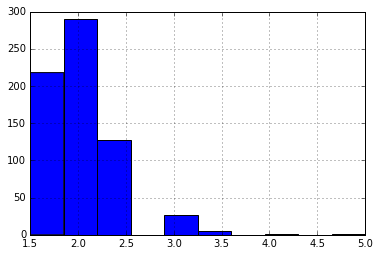

In [68]:
students['Time of stay'].hist()

Most of the student finished their master in 1.5 to 2.5 years, a few in more than that.

In [69]:
students['Time of stay'].describe()

count    668.000000
mean       1.989521
std        0.452258
min        1.500000
25%        1.500000
50%        2.000000
75%        2.000000
max        5.000000
Name: Time of stay, dtype: float64

We have an average of 1.98 years for a master, the minimum is of 1.5 as expected. We have a student that took five years to complete his master, let's look if the data is coherent.

In [70]:
students_1[(students_1['Time of stay']==5)]



sex          name  sciper  year_master1  \
331  Monsieur  Marx Clément  146742        2008.5   

                     specialisation mineur  year_master2_earliest  \
331  Signals, Images and Interfaces    NaN                 2009.0   

     year_master2_latest  year_master3  year_pdm  Beginning  Ending  \
331               2010.0        2012.5       NaN     2008.5  2012.5   

     Difference  Time of stay  
331         4.0           5.0

Clément Marx seemed to have started his master in September 2008, did two semesters then stopped, started again for one semester and did his second semester in January 2009. Then he stopped for two years and finally did his last semester (master 3) in automn 2012, and we assume that he then directly did his master thesis

### Specialisation data

Let's first keep only student with a specialisation

In [71]:
specialisation=students[~pd.isnull(students['specialisation'])]
specialisation.head(10)


sex                      name  sciper  \
155  Monsieur  Engilberge Martin Pierre  212790   
161  Monsieur               Gaspoz John  212859   
195  Monsieur           Piskas Georgios  244587   
205  Monsieur              Schegg Elias  195675   
210  Monsieur    Valette Laurent Michel  205864   
238  Monsieur            Campora Simone  180072   
257  Monsieur              Hofer Thomas  165819   
275  Monsieur       Muriel Hugo Marcelo  179878   
463  Monsieur      Bricola Jean-Charles  180731   
953  Monsieur      Duhem Martin Nicolas  214632   

                     specialisation mineur  Beginning  Time of stay  
155              Internet computing    NaN     2014.5           2.5  
161       Information Security - SP    NaN     2014.5           2.5  
195                Software Systems    NaN     2014.5           2.5  
205              Internet computing    NaN     2014.5           2.5  
210                Software Systems    NaN     2014.5           2.5  
238              Internet computing    NaN     2007.5           2.0  
257         Foundations of Software    NaN     2007.5           2.0  
275              Internet computing    NaN     2007.5           2.0  
463  Signals, Images and Interfaces    NaN     2010.5           2.0  
953         Foundations of Software    NaN     2015.0           2.0

Let's now have a look on students having a specialisation 

Time of stay
count    112.000000
mean       2.308036
std        0.451452
min        1.500000
25%        2.000000
50%        2.000000
75%        2.500000
max        5.000000

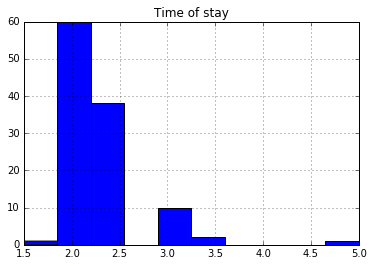

In [127]:
specialisation=specialisation[['specialisation','Time of stay']]

specialisation.hist()
specialisation.describe()




The average stays for people with a specialisation is of 2.308. There is still that one student who did 5 years. There seems to be one guy that did 1.5 year. Let's have a look at the data from that student to see if that's possible.

In [73]:
students_1[(students_1['Time of stay']==1.5) & ~pd.isnull(students_1['specialisation'])]



sex           name  sciper  year_master1           specialisation  \
1069  Monsieur  Steiger Robin  175702           NaN  Foundations of Software   

     mineur  year_master2_earliest  year_master2_latest  year_master3  \
1069    NaN                 2010.0               2010.0        2010.5   

      year_pdm  Beginning  Ending  Difference  Time of stay  
1069    2011.0     2010.0  2011.0         1.0           1.5

He has been registered in a master thesis so that is a pretty good sign that he finished his master. It is possible that he started his Master in Spring, so is-academia will consider him as master 2 straight away. Then he did master 3. He must have done 90 credits in two semesters which is, I've seen students who did it, possible.

Let's now have a look at specific specialisations.

In [75]:
time_of_stay_avg= specialisation.groupby(['specialisation'])['Time of stay'].mean().sort_values()


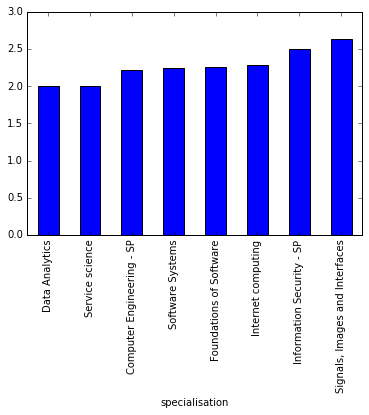

In [76]:
time_of_stay_avg.plot.bar()

Let's now do a welsh test between the average stay for each specialisation and the general average stay.

In [77]:
test = dict()
for n in specialisation['specialisation']:
    spe=specialisation[(specialisation['specialisation']==n)]    
    c=stats.ttest_ind(students['Time of stay'], spe['Time of stay'], equal_var = False)
    test[n]=c
    
    



C:\Users\Mathieu\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [78]:
test

{'Computer Engineering - SP': Ttest_indResult(statistic=-2.5980698395921573, pvalue=0.029761697611030639),
 'Data Analytics': Ttest_indResult(statistic=nan, pvalue=nan),
 'Foundations of Software': Ttest_indResult(statistic=-4.0784914386525175, pvalue=0.00019932098988213059),
 'Information Security - SP': Ttest_indResult(statistic=nan, pvalue=nan),
 'Internet computing': Ttest_indResult(statistic=-4.6123647150076987, pvalue=3.0858143502299197e-05),
 'Service science': Ttest_indResult(statistic=-0.59885699049194718, pvalue=0.54947157993437723),
 'Signals, Images and Interfaces': Ttest_indResult(statistic=-3.2388574016719058, pvalue=0.0058407301468249191),
 'Software Systems': Ttest_indResult(statistic=-2.3017743423656305, pvalue=0.067150092073042358)}

We can see that there are some specialisation for which the avergae time of stay is significantly different. This is the case for "Foundations of Software", "Internet computing" and "Signal, Images and Interfaces".

The test could not be done for "Data Analytics" and "Information Security - SP" probably because there are not enough data. Let's check for Data Analytics

In [79]:
specialisation[(specialisation['specialisation']=='Data Analytics')].count()



specialisation    1
Time of stay      1
dtype: int64

Yes Indeed, we only have one student registered in Data analytics and this can never be statistically representative

### Bonus : gender-based study
partitioning data along genders

In [86]:
masterF = students[students['sex']=='Madame']
masterM = students[students['sex']=='Monsieur']


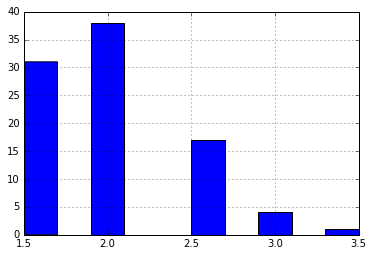

In [87]:
masterF['Time of stay'].hist()

In [92]:
masterF['Time of stay'].mean()

1.9835164835164836

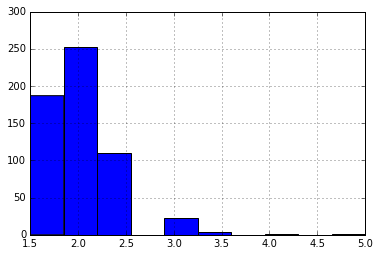

In [93]:
masterM['Time of stay'].hist()


In [94]:
masterM['Time of stay'].mean()

1.990467937608319

In [95]:
stats.ttest_ind(masterM['Time of stay'], masterF['Time of stay'], equal_var = False)

Ttest_indResult(statistic=0.13683148245575583, pvalue=0.89139219253903479)

Data shows that there is no significant average difference in Master studies' length between female and male student population.

(2007.5, 2015.5)

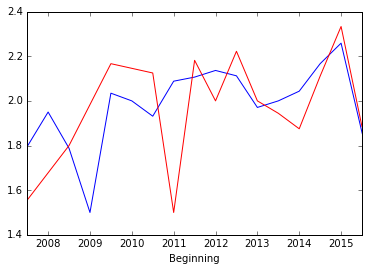

In [283]:
masterAvgF = masterF.groupby('Beginning')
masterAvgF = masterAvgF['Time of stay'].mean()
masterAvgM = masterM.groupby('Beginning')
masterAvgM = masterAvgM['Time of stay'].mean()
plt.ticklabel_format(useOffset=False)

masterAvgM.plot(color='blue')
masterAvgF.plot(color='red')
plt.xlim(2007.5, 2015.5)

Plotting the average length of stay per year of beginning of male students students against that of female students does not visually show a remarkable feature. The only valid information we may extract, is that Master studies tend on average to last longer from the start of our sample to its end, showing a global tendency for both genders.

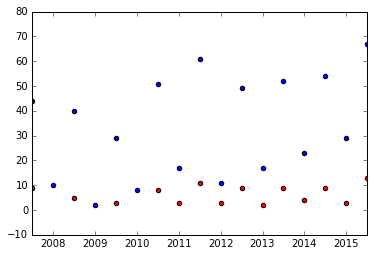

In [281]:
masterNbF = masterF.groupby('Beginning')
masterNbF = masterNbF['sex'].count()
masterNbM = masterM.groupby('Beginning')
masterNbM = masterNbM['sex'].count()

plt.scatter(masterNbF.index, masterNbF, c='red')
plt.scatter(masterNbM.index, masterNbM, c='blue')

plt.xlim(2007.5, 2015.5)
plt.ticklabel_format(useOffset=False)

Plotting the number of new students per year of beginning obviously shows that female students are underrepresented amongst each promotion, but also shows much more stability, especially between spring and autumn semesters where the number of male new students appears to vary lot. It also seems that the number of new female students does not follow the same tendency to grow as the number of male students does.